# KPOP tutorial

This tutorial is an introduction to the  KLIP POst Processing (KPOP) framework.
It includes the calculation of matched filter maps, SNR maps, detection, ROC curve and contrast curves calculation.

KPOP has been implemented with surveys application in mind. It includes several wrapper functions, which all ihnerit from the same object, and performing different tasks like matched filters, SNR map calculation, detection of high SNR blobs and others. A lot features have been automated and are therefore hidden from the user, which is appreciable when running the same sequence of tasks and many datasets.


## Preliminary

Execute the following lines before each other sections.
Depending on your system, the mkl module might be necessary.
Refer to http://pyklip.readthedocs.io/en/latest/install.html#note-on-parallelized-performance for use of mkl.

We have noticed that sometimes the notebook hangs probably because of the parallelization. In such a case, running the code in a normal python script should work.

In [8]:
try:
    import mkl
    mkl.set_num_threads(1)
except:
    print("Your code might run slowly.")
    print("/!\ Please Read http://pyklip.readthedocs.io/en/latest/install.html#note-on-parallelized-performance")
    
import os
import glob
import numpy as np
import pyklip.instruments.GPI as GPI
import pyklip.parallelized as parallelized

pykliproot = os.path.dirname(os.path.realpath(parallelized.__file__))
inputDir = os.path.join(pykliproot,"..","tests","data")
outputDir = inputDir

## Speckle subtraction
The matched filter should be performed on speckle subtracted dataset so let's reduce a test dataset with PyKlip using http://pyklip.readthedocs.io/en/latest/klip_gpi.html.
This step can be skipped if reduced images are already available. Read dataset and run speckle subtraction:

In [3]:
# Read the datacubes using the GPIData object
filelist = glob.glob(os.path.join(inputDir,"*spdc_distorcorr.fits"))
dataset = GPI.GPIData(filelist,highpass=True,meas_satspot_flux=False,numthreads=None)

parallelized.klip_dataset(dataset, outputdir=outputDir, fileprefix="bet_Pic_test",
                          annuli=9, subsections=4, movement=1, numbasis=[1,20,50,100],
                          calibrate_flux=True, mode="ADI+SDI")

Reading File: /home/sda/jruffio/pyklip/pyklip/../tests/data/S20131210S0111_spdc_distorcorr.fits
Reading File: /home/sda/jruffio/pyklip/pyklip/../tests/data/S20131210S0099_spdc_distorcorr.fits
Reading File: /home/sda/jruffio/pyklip/pyklip/../tests/data/S20131210S0092_spdc_distorcorr.fits
Beginning ADI+SDI KLIP
Begin align and scale images for each wavelength
Wavelength 1.257 with index 22 has finished align and scale. Queuing for KLIP
Wavelength 1.11 with index 0 has finished align and scale. Queuing for KLIP
Wavelength 1.238 with index 19 has finished align and scale. Queuing for KLIP
Wavelength 1.284 with index 26 has finished align and scale. Queuing for KLIP
Wavelength 1.128 with index 1 has finished align and scale. Queuing for KLIP
Wavelength 1.139 with index 3 has finished align and scale. Queuing for KLIP
Wavelength 1.157 with index 6 has finished align and scale. Queuing for KLIP
Wavelength 1.163 with index 7 has finished align and scale. Queuing for KLIP
Wavelength 1.205 with 

/home/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


## Cross Correlation

The cross correlation is the most basic type of matched filter. It assumes that the noise is identically distributed for all the pixels in the image. See discussion in Ruffio et al. (2017).

The following shows different cases for applying the cross correlation.

### Single cube. Independent slices.

For example, pyklip produces fits cube where each slice is the a collapsed spectral cube but using different number of KL modes (filename suffix is KLmodes-all). CrossCorr will process each slice independently.

The method check_existence() allows to check for the existence of the processed file. You might want to skip it if it already exists.

~~ INITializing CrossCorr ~~
Reading File: /home/sda/jruffio/pyklip/tests/data/bet_Pic_test-KLmodes-all.fits
Generate gaussian PSF
Does the processed file exist? False
~~ Calculating CrossCorr with parameters crossCorrgaussian ~~
Saving: /home/sda/jruffio/pyklip/tests/data/kpop_pyklip/default_out/bet_Pic_test-KLmodes-all-crossCorrgaussian.fits
/home/sda/jruffio/pyklip/tests/data/kpop_pyklip/default_out/bet_Pic_test-KLmodes-all-crossCorrgaussian.fits
Output already exist: /home/sda/jruffio/pyklip/tests/data/kpop_pyklip/default_out/bet_Pic_test-KLmodes-all-crossCorrgaussian.fits
Does the processed file exist? True


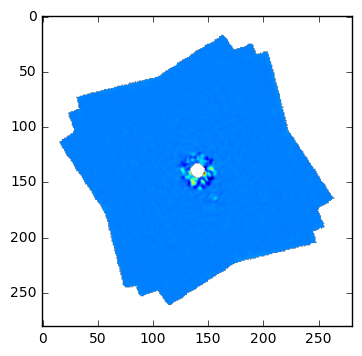

In [4]:
from pyklip.kpp.metrics.crossCorr import CrossCorr

# Definition of the cross correlation object
filename = "bet_Pic_test-KLmodes-all.fits"
read_func = lambda file_list:GPI.GPIData(file_list,recalc_centers=False,recalc_wvs=False,highpass=False)
cc_obj = CrossCorr(read_func,filename,kernel_type="gaussian",kernel_para=1.0,label="pyklip")

cc_obj.initialize(inputDir=inputDir,
                   outputDir=outputDir)
#check if the processed data exists
print("Does the processed file exist? {0}".format(cc_obj.check_existence()))
# Run cross correlation
cc_image = cc_obj.calculate()
# Save data to #pykliproot#/../tests/data/kpop_pyklip/default_out/bet_Pic_test-KLmodes-all-crossCorrgaussian.fits
cc_obj.save()
#check if the processed data exists
print("Does the processed file exist? {0}".format(cc_obj.check_existence()))

%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(cc_image[2,::-1,:])

### Single Spectral Cube

For example, pyklip produces spectral cube with the suffix "speccube". CrossCorr can first collapse the cube with a given spectrum before running the cross correlation using the two keywords "collapse=True,spectrum=spectrum". Here we are using the atmospheric models from Marley et al. (2017, in prep.) and Saumon et al. 2012.

~~ INITializing CrossCorr ~~
Reading File: /home/sda/jruffio/pyklip/tests/data/bet_Pic_test-KL20-speccube.fits
Generate gaussian PSF
~~ UPDATE Spectrum CrossCorr ~~
Spectrum model: /home/sda/jruffio/pyklip/pyklip/spectra/cloudy/t1300g100f2.flx
~~ Calculating CrossCorr with parameters crossCorrgaussian ~~
Saving: /home/sda/jruffio/pyklip/tests/data/kpop_pyklip/t1300g100f2/bet_Pic_test-KL20-speccube-crossCorrgaussian.fits
/home/sda/jruffio/pyklip/tests/data/kpop_pyklip/t1300g100f2/bet_Pic_test-KL20-speccube-crossCorrgaussian.fits


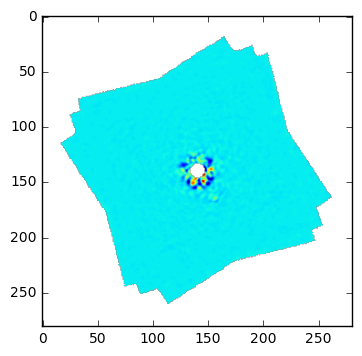

In [5]:
from pyklip.kpp.metrics.crossCorr import CrossCorr

# Define the spectrum from its name
spectrum = "t1300g100f2"
# Spectrum can also be user defined as commented in the line below.
#spectrum = np.ones(37)
folderName = "t1300g100f2"

# Definition of the cross correlation object
filename = "bet_Pic_test-KL20-speccube.fits"
read_func = lambda file_list:GPI.GPIData(file_list,recalc_centers=False,recalc_wvs=False,highpass=False)
cc_obj = CrossCorr(read_func,filename,kernel_type="gaussian",kernel_para=1.0,label="pyklip",
                   collapse=True,spectrum=spectrum,folderName=folderName)

cc_obj.initialize(inputDir=inputDir,
                   outputDir=outputDir)
cc_image = cc_obj.calculate()
cc_obj.save()

%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(cc_image[::-1,:])

### SNR calculation

StatPerPix can be used to estimate the SNR maps. It estimate the standard deviation for each pixel in an annulus at the same separation from which the surroundings of the pixel has been masked.

Note that by not specifying the outputDir in the SNR calculation, the label and the folderName is inferred from the cross correlation map path.

~~ INITializing Stat ~~
Reading File: /home/sda/jruffio/pyklip/tests/data/kpop_pyklip/t1300g100f2/bet_Pic_test-KL20-speccube-crossCorrgaussian.fits
~~ Calculating Stat with parameters SNRPerPixDr2 ~~
Saving: /home/sda/jruffio/pyklip/tests/data/kpop_pyklip/t1300g100f2/bet_Pic_test-KL20-speccube-crossCorrgaussian-SNRPerPixDr2.fits
The SNR peak in the image is 31.42 sigma.


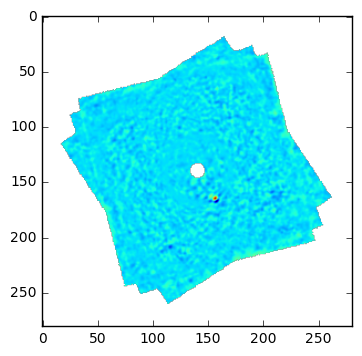

In [6]:
from pyklip.kpp.stat.stat import Stat

# Definition of the SNR object
read_func = lambda file_list:GPI.GPIData(file_list,recalc_centers=False,recalc_wvs=False,highpass=False)
filename = os.path.join("kpop_pyklip","t1300g100f2","bet_Pic_test-KL20-speccube-crossCorrgaussian.fits")
snr_obj = Stat(read_func,filename,type="pixel based SNR")

snr_obj.initialize(inputDir=inputDir)
snr_image = snr_obj.calculate()
snr_obj.save()

print("The SNR peak in the image is {0:.2f} sigma.".format(np.nanmax(snr_image)))
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(snr_image[::-1,:])

### Multiple files with different reduction spectra

KPOP has been optimized to ease the reduction of survey data. Reducing one or several files requires the same number of lines of code. The function automating the process is called kppPerDir and take a list of objects (ie tasks to be executed) and a list of spectrum over which to iterate. Each object knows if it has to iterate over the spectra or not. For example the SNR calculation will be insensitive to spectrum_list.

kppPerDir will automatically iterate over all the files matching the filename description (using wildcards).

If overwrite kept False, kppPerDir automatically verifies that the files has not already been processed.

In [7]:
spectrum_list = [np.ones(37),"t600g100nc","t1300g100f2"]

read_func = lambda file_list:GPI.GPIData(file_list,recalc_centers=False,recalc_wvs=False,highpass=False)

# Definition of the cross correlation object
from pyklip.kpp.metrics.crossCorr import CrossCorr
filename = "bet_Pic_test-KL*-speccube.fits"
cc_obj = CrossCorr(read_func,filename,kernel_type="gaussian",kernel_para=1.0,label="pyklip",collapse=True)

# Definition of the SNR object
from pyklip.kpp.stat.stat import Stat
filename = os.path.join("kpop_pyklip","*","bet_Pic_test-KL*-speccube-crossCorrgaussian.fits")
snr_obj = Stat(read_func,filename,type="pixel based SNR")

# Process all matching files
from pyklip.kpp.kpop_wrapper import kpop_wrapper
err_list = kpop_wrapper(inputDir,[cc_obj,snr_obj],spectrum_list=spectrum_list,mute_error = False)

# One can check if reductions have failed here
print("Printing error report:")
for err_str in err_list:
    print(err_str)

~~ INITializing CrossCorr ~~
Reading File: /home/sda/jruffio/pyklip/tests/data/bet_Pic_test-KL100-speccube.fits
Generate gaussian PSF
~~ UPDATE Spectrum CrossCorr ~~
~~ Calculating CrossCorr with parameters crossCorrgaussian ~~
Saving: /home/sda/jruffio/pyklip/tests/data/kpop_pyklip/custom/bet_Pic_test-KL100-speccube-crossCorrgaussian.fits
/home/sda/jruffio/pyklip/tests/data/kpop_pyklip/custom/bet_Pic_test-KL100-speccube-crossCorrgaussian.fits
~~ UPDATE Spectrum CrossCorr ~~
Spectrum model: /home/sda/jruffio/pyklip/pyklip/spectra/g100ncflx/t600g100nc.flx
~~ Calculating CrossCorr with parameters crossCorrgaussian ~~
Saving: /home/sda/jruffio/pyklip/tests/data/kpop_pyklip/t600g100nc/bet_Pic_test-KL100-speccube-crossCorrgaussian.fits
/home/sda/jruffio/pyklip/tests/data/kpop_pyklip/t600g100nc/bet_Pic_test-KL100-speccube-crossCorrgaussian.fits
~~ UPDATE Spectrum CrossCorr ~~
Spectrum model: /home/sda/jruffio/pyklip/pyklip/spectra/cloudy/t1300g100f2.flx
~~ Calculating CrossCorr with paramete

## Matched Filter

Here, we make a difference between matched filter and cross correlation. The cross correlation doesn't account for noise variation in the image while the matched filter does. There is a normalization by the local standard deviation, which is estimated from the image/cube directly. See discussion in Ruffio et al. (2017).

The matched filter class doesn't work cubes with indepedent slices. Here we show an example with a spectral datacube.
The multiple file calculation works as before.

### Single Spectral Cube

~~ INITializing Matchedfilter ~~
Reading File: /home/sda/jruffio/pyklip/tests/data/bet_Pic_test-KL20-speccube.fits
Generate gaussian PSF
~~ UPDATE Spectrum Matchedfilter ~~
Spectrum model: /home/sda/jruffio/pyklip/pyklip/spectra/cloudy/t1300g100f2.flx
~~ Calculating Matchedfilter with parameters 3Dgaussian ~~
Calculate the matched filter maps. It is done pixel per pixel so it might take a while...
Saving: /home/sda/jruffio/pyklip/tests/data/kpop_pyklip/t1300g100f2/bet_Pic_test-KL20-speccube-MF3Dgaussian.fits
Saving: /home/sda/jruffio/pyklip/tests/data/kpop_pyklip/t1300g100f2/bet_Pic_test-KL20-speccube-CC3Dgaussian.fits
Saving: /home/sda/jruffio/pyklip/tests/data/kpop_pyklip/t1300g100f2/bet_Pic_test-KL20-speccube-Flux3Dgaussian.fits
(53.631099008023568, 0.00062362630283584045, 0.0092446542406163547)


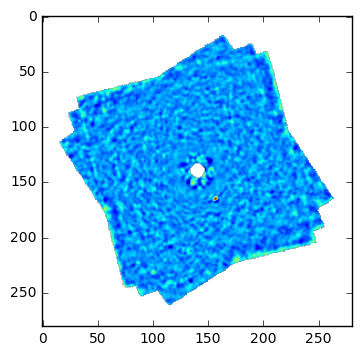

In [8]:
from pyklip.kpp.metrics.matchedfilter import Matchedfilter

# Define the spectrum from its name
spectrum = "t1300g100f2"
# Spectrum can also be user defined as commented in the line below.
#spectrum = np.ones(37)
folderName = "t1300g100f2"

# Definition of the cross correlation object
filename = "bet_Pic_test-KL20-speccube.fits"
read_func = lambda file_list:GPI.GPIData(file_list,recalc_centers=False,recalc_wvs=False,highpass=False)
mf_obj = Matchedfilter(read_func,filename,kernel_type="gaussian",kernel_para=1.0,label="pyklip",
                       spectrum=spectrum,folderName=folderName)

mf_obj.initialize(inputDir=inputDir,
                   outputDir=outputDir)
out = mf_obj.calculate()
mf_map,cc_map,flux_map = out
mf_obj.save()

%matplotlib inline
import matplotlib.pyplot as plt
print(np.nanmax(mf_map),np.nanmax(cc_map),np.nanmax(flux_map))
plt.imshow(mf_map[::-1,:])

### SNR calculation

Again, let's calculate the SNR in exactly the same manner.

~~ INITializing Stat ~~
Reading File: /home/sda/jruffio/pyklip/tests/data/kpop_pyklip/t1300g100f2/bet_Pic_test-KL20-speccube-MF3Dgaussian.fits
~~ Calculating Stat with parameters SNRPerPixDr2 ~~
Saving: /home/sda/jruffio/pyklip/tests/data/kpop_pyklip/t1300g100f2/bet_Pic_test-KL20-speccube-MF3Dgaussian-SNRPerPixDr2.fits
The SNR peak in the image is 22.38 sigma.


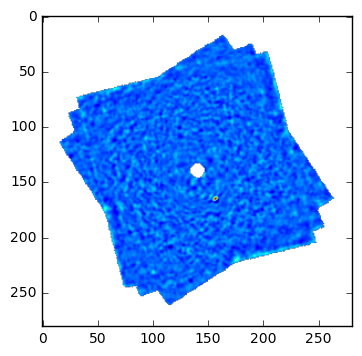

In [9]:
from pyklip.kpp.stat.stat import Stat

# Definition of the SNR object
read_func = lambda file_list:GPI.GPIData(file_list,recalc_centers=False,recalc_wvs=False,highpass=False)
filename = os.path.join("kpop_pyklip","t1300g100f2","bet_Pic_test-KL20-speccube-MF3Dgaussian.fits")
snr_obj = Stat(read_func,filename,type="pixel based SNR")

snr_obj.initialize(inputDir=inputDir)
snr_image = snr_obj.calculate()
snr_obj.save()

print("The SNR peak in the image is {0:.2f} sigma.".format(np.nanmax(snr_image)))
import matplotlib.pyplot as plt
plt.imshow(snr_image[::-1,:])

## Forward Model Matched Filter

The problem with the previous matched filters is that they don't account for the distortion of the planet PSF through KLIP. Therefore their matched filter template is innacurate. The Forward Model Matched Filter (FMMF) models the self-subtraction at each pixel (called Forward Model) and use the more accurate model in the matched filter. In addition, FMMF runs the matched filter on uncollapse datasets. This code takes about a factor 10 longer than the regular KLIP reduction. 

Reading File: /home/sda/jruffio/pyklip/pyklip/../tests/data/S20131210S0111_spdc_distorcorr.fits
Reading File: /home/sda/jruffio/pyklip/pyklip/../tests/data/S20131210S0099_spdc_distorcorr.fits
Reading File: /home/sda/jruffio/pyklip/pyklip/../tests/data/S20131210S0092_spdc_distorcorr.fits


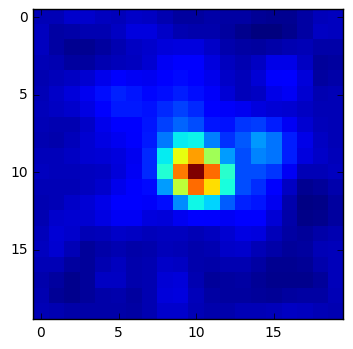

In [3]:
from pyklip.kpp.metrics.FMMF import FMMF
from pyklip.instruments import GPI

# Generate PSF cube for GPI from the satellite spots
filenames = glob.glob(os.path.join(inputDir,"S*distorcorr.fits"))
dataset = GPI.GPIData(filenames,highpass=True)
dataset.generate_psf_cube(20,same_wv_only=True)
PSF_cube_path = inputDir + os.path.sep + "beta_Pic_test"+"-original_PSF_cube.fits"
# Save the original PSF calculated from combining the sat spots
dataset.savedata(PSF_cube_path, dataset.psfs, filetype="PSF Spec Cube")

# Plot the flattened PSF cube
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(np.mean(dataset.psfs,axis=0),interpolation="nearest")

Reading File: /home/sda/jruffio/pyklip/pyklip/../tests/data/S20131210S0111_spdc_distorcorr.fits
Reading File: /home/sda/jruffio/pyklip/pyklip/../tests/data/S20131210S0099_spdc_distorcorr.fits
Reading File: /home/sda/jruffio/pyklip/pyklip/../tests/data/S20131210S0092_spdc_distorcorr.fits
~~ INITializing FMMF ~~


/home/anaconda/lib/python2.7/site-packages/scipy/interpolate/fitpack2.py:1101: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=129). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  warnings.warn(message)


Reading File: /home/sda/jruffio/pyklip/tests/data/S20131210S0092_spdc_distorcorr.fits
Reading File: /home/sda/jruffio/pyklip/tests/data/S20131210S0099_spdc_distorcorr.fits
Reading File: /home/sda/jruffio/pyklip/tests/data/S20131210S0111_spdc_distorcorr.fits
Spectrum model: /home/sda/jruffio/pyklip/pyklip/spectra/cloudy/t1300g100f2.flx
Loading PSF cube: /home/sda/jruffio/pyklip/tests/data/beta_Pic_test-original_PSF_cube.fits
Reading File: /home/sda/jruffio/pyklip/tests/data/beta_Pic_test-original_PSF_cube.fits
Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/48
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time
 100.00% of sector, 2.08% of total completed
Starting KLIP for sector 2/48
Time spent on last sector: 19s
Time spent since beginning: 19s
Estimated remaining time: 903s
 100.00% of sector, 4.17% of total completed
Starting KLIP for sector 3/48
Time spent on last sector: 19s
Ti

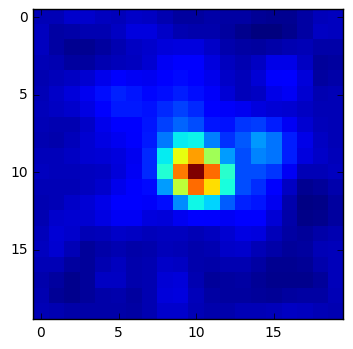

In [2]:
# Define the function to read the dataset files.
# In order to show a more advanced feature, in this case the satellite spots fluxes
# are reestimated using the PSF cube calculated previously 
read_func = lambda file_list:GPI.GPIData(file_list,
                                         meas_satspot_flux=True,
                                         numthreads = None,
                                         highpass=True,
                                         PSF_cube="*-original_PSF_cube.fits")
# Filename for the raw spectral cubes
filename = "S*distorcorr.fits"
# Define PSF cube from file. Optionnaly, you can input an array instead.
PSF_cube,PSF_cube_wvs = "*-original_PSF_cube.fits",None
# Define the function to read the PSF cube file. 
# You can choose to directly give an array as the PSF cube and not bother with this.
PSF_read_func = lambda file_list:GPI.GPIData(file_list,highpass=False)
# reduction spectrum for the forward model and the reference library selection
spectrum = "t1300g100f2"

FMMFObj = FMMF(read_func,filename = filename,
               spectrum=spectrum,
               PSF_read_func = PSF_read_func,
               PSF_cube = PSF_cube,
               PSF_cube_wvs = PSF_cube_wvs,
               predefined_sectors = "0.6 as",
               label = "FMMF",
               overwrite=True,
               numbasis=[5],
               maxnumbasis = 10,
               mvt=1.0)
FMMFObj.initialize(inputDir=inputDir,
                   outputDir=outputDir)
FMMFObj.calculate()
FMMFObj.save()

## Planet Detection

The detection steps simply consists in spotting the brighter blobs in a SNR maps. The Detection class generate a table saved a .csv file with an order list of these blobs with their SNR and position.

In [4]:
from pyklip.kpp.detection.detection import Detection

read_func = lambda file_list:GPI.GPIData(file_list,recalc_centers=False,recalc_wvs=False,highpass=False)
filename = os.path.join("kpop_pyklip","t1300g100f2","bet_Pic_test-KL20-speccube-MF3Dgaussian-SNRPerPixDr2.fits")
detec_obj = Detection(read_func,filename,threshold = 3,pix2as = GPI.GPIData.lenslet_scale)

# calculate and save the detected blob
detec_obj.initialize(inputDir=inputDir)
detec_obj.calculate()
detec_obj.save()

~~ INITializing Detection ~~
Reading File: /home/sda/jruffio/pyklip/tests/data/kpop_pyklip/t1300g100f2/bet_Pic_test-KL20-speccube-MF3Dgaussian-SNRPerPixDr2.fits
~~ Calculating Detection with parameters DetecTh3Mr4 ~~
Saving: /home/sda/jruffio/pyklip/tests/data/kpop_pyklip/t1300g100f2///bet_Pic_test-KL20-speccube-MF3Dgaussian-SNRPerPixDr2-DetecTh3Mr4.csv


Plot the detected blobs:

Reading File: /home/sda/jruffio/pyklip/pyklip/../tests/data/kpop_pyklip/t1300g100f2/bet_Pic_test-KL20-speccube-MF3Dgaussian-SNRPerPixDr2.fits


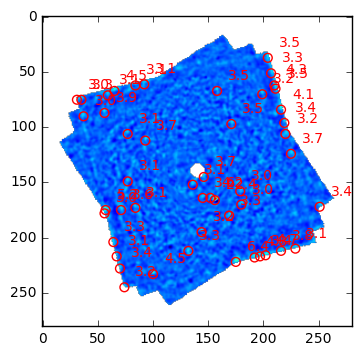

In [5]:
filename = os.path.join(inputDir,"kpop_pyklip","t1300g100f2",
                        "bet_Pic_test-KL20-speccube-MF3Dgaussian-SNRPerPixDr2.fits")
snr_image = GPI.GPIData([filename],highpass=False).input[0,:,:]
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(snr_image[::-1,:])

import csv
filename = os.path.join(inputDir,"kpop_pyklip","t1300g100f2",
                        "bet_Pic_test-KL20-speccube-MF3Dgaussian-SNRPerPixDr2-DetecTh3Mr4.csv")
with open(filename, 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    csv_as_list = list(reader)
    detec_table_labels = csv_as_list[0]
    detec_table = np.array(csv_as_list[1::], dtype='string').astype(np.float)

metric_id = detec_table_labels.index("value")
row_id = detec_table_labels.index("row")
col_id = detec_table_labels.index("col")

ax = plt.gca()
ny,nx = snr_image.shape
for snr,row,col in zip(detec_table[:,metric_id],detec_table[:,row_id],detec_table[:,col_id]):
    circle=plt.Circle((col,ny-row),radius=4.,color='r',fill=False)
    ax.add_artist(circle)
    ax.annotate("{0:.1f}".format(snr), fontsize=10, color = "red",xy=(col,ny-row),
                xycoords='data', xytext=(col+10, ny-row-10))

## Receiver Operating Characteristic (ROC)

We have attached a python script to calculate the ROC curves for the GPI data available in test. It includes simulated planets injection.
roc_script.py is the script but can also be called as a function.
The script is simply an example and should be adapted to anyone's applications. A few parameters are hard-coded at the begining of the function.

In [10]:
from roc_script import roc_dataset

inputDir = "/home/sda/jruffio/pyklip/tests/data/"
dir_fakes = "/home/sda/jruffio/pyklip/tests/data-Fakes/"

mvt = 0.7
reduc_spectrum = "t600g100nc"
fakes_spectrum = "t1000g100nc"

#roc_dataset(inputDir,dir_fakes,mvt,reduc_spectrum,fakes_spectrum)

### Plot the ROC curves:

Combining the ROC curve of individual dataset by simply adding both axes together will result in a real ROC curve.

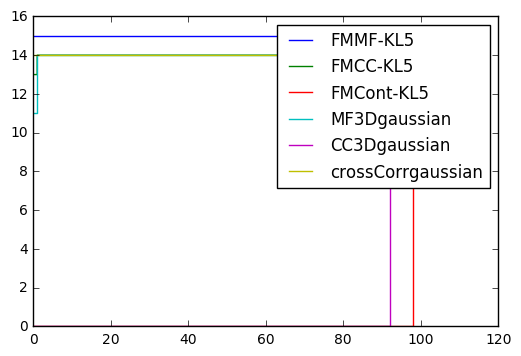

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

reductions_type_list = ["FMMF-KL5",
                        "FMCC-KL5",
                        "FMCont-KL5",
                        "MF3Dgaussian",
                        "CC3Dgaussian",
                        "crossCorrgaussian"]

import csv
for red_type in reductions_type_list:
    filename = os.path.join(dir_fakes,
                            "kpop_FMMF_ROC"
                            ,reduc_spectrum,
                            "*{0}-SNRPerPixDr2-DetecTh2Mr4-ROC.csv".format(red_type))
    filename = glob.glob(filename)[0]
    with open(filename, 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        csv_as_list = list(reader)
        table_labels = csv_as_list[0]
        detec_table = np.array(csv_as_list[1::], dtype='string').astype(np.float)
        thresholds = detec_table[:,0]
        FPs = detec_table[:,1]
        TPs = detec_table[:,2]
    plt.plot(FPs,TPs,label=red_type)
plt.legend()

## Contrast Curves

In [16]:
from contrast_script import contrast_dataset

inputDir = "/home/sda/jruffio/pyklip/tests/data/"
dir_fakes = "/home/sda/jruffio/pyklip/tests/data-Fakes/"

mvt = 0.7
# T-type
reduc_spectrum = "t600g100nc"
fakes_spectrum = "t1000g100nc"
approx_throughput = 0.5
## L-type
# reduc_spectrum = "t1300g100f2"
# fakes_spectrum = "t1300g100f2"
# approx_throughput = 0.7

#contrast_dataset(inputDir,dir_fakes,mvt,reduc_spectrum,fakes_spectrum,approx_throughput)

### Plot the contrast curve for the different reductions

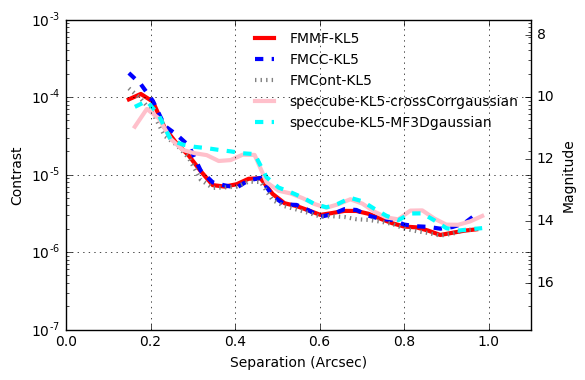

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

inputDir = "/home/sda/jruffio/pyklip/tests/data/"
reduc_spectrum = "t600g100nc"
fakes_spectrum = "t1000g100nc"

suffix_list = ["FMMF-KL5","FMCC-KL5","FMCont-KL5",
               "speccube-KL5-crossCorrgaussian",
               "speccube-KL5-MF3Dgaussian"]
label_list = ["kpop_FMMF",]*5
linestyle_list = ["-","--",":","-","--"]
color_list = ["red","blue","grey","pink","cyan"]

fig = plt.figure(1)
for suffix,linestyle,color,kpop_label in zip(suffix_list,linestyle_list,color_list,label_list):
    with open(os.path.join(inputDir,kpop_label,reduc_spectrum,"contrast-"+suffix+'.csv'), 'rt') as cvs_contrast:
        cvs_contrast_reader = csv.reader(filter(lambda row: row[0]!="#",cvs_contrast),delimiter=' ')
        list_contrast = list(cvs_contrast_reader)
        contrast_str_arr = np.array(list_contrast, dtype='string')
        col_names = contrast_str_arr[0]
        contrast_arr = contrast_str_arr[1::].astype(np.float)
        sep_cont_samples = contrast_arr[:,0]
        contrast = np.squeeze(contrast_arr[:,np.where(fakes_spectrum==col_names)])

    plt.plot(sep_cont_samples,contrast,linestyle=linestyle, color=color, linewidth=3.0)
    
plt.xlabel("Separation (Arcsec)", fontsize=10)
plt.ylabel("Contrast", fontsize=10)
plt.legend(suffix_list,frameon=False,loc="upper right",fontsize=10,framealpha=0.)
ax= plt.gca()
ax.set_yscale('log')
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
plt.grid(True)
plt.ylim([1e-7,1e-3])
plt.xlim([0.0,1.1])

ax2 = fig.add_subplot(1,1,1,sharex=ax,frameon=False)
plt.ylim([-2.5*np.log10(1e-3),-2.5*np.log10(1e-7)])
ax2.invert_yaxis()
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.get_xaxis().set_visible(False)
ax2.tick_params(labelsize = 10)
plt.ylabel("Magnitude", fontsize=10)


### Plot the conversion factor for the different reductions

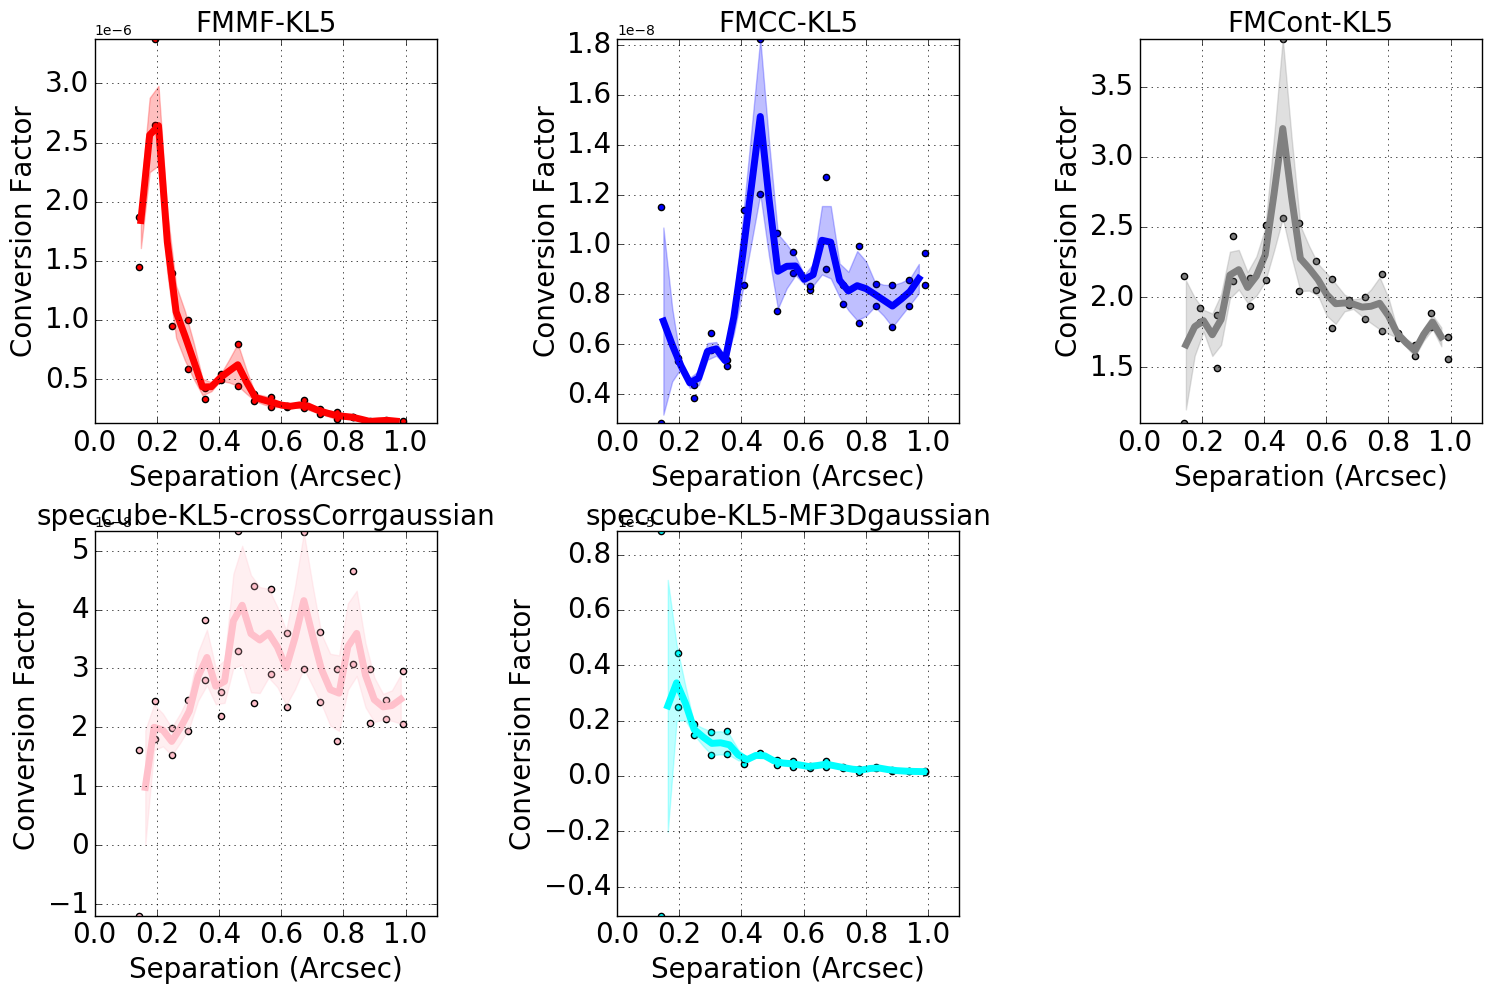

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

inputDir = "/home/sda/jruffio/pyklip/tests/data/"
reduc_spectrum = "t600g100nc"
fakes_spectrum = "t1000g100nc"

suffix_list = ["FMMF-KL5","FMCC-KL5","FMCont-KL5",
               "speccube-KL5-crossCorrgaussian",
               "speccube-KL5-MF3Dgaussian"]
label_list = ["kpop_FMMF",]*5
color_list = ["red","blue","grey","pink","cyan"]


plt.figure(2,figsize=(15,10))
for k,(suffix,color,kpop_label) in enumerate(zip(suffix_list,color_list,label_list)):
    plt.subplot(2,3,k+1)
    with open(os.path.join(inputDir,kpop_label,reduc_spectrum,"contrast-"+suffix+'.csv'), 'rt') as cvs_contrast:
        cvs_contrast_reader = csv.reader(filter(lambda row: row[0]!="#",cvs_contrast),delimiter=' ')
        list_contrast = list(cvs_contrast_reader)
        contrast_str_arr = np.array(list_contrast, dtype='string')
        col_names = contrast_str_arr[0]
        contrast_arr = contrast_str_arr[1::].astype(np.float)
        sep_cont_samples = contrast_arr[:,0]
        # csvwriter.writerows([["Seps",spec_type,spec_type+"_kMAD",spec_type+"_1sig",spec_type+"_conv",spec_type+"_conv_kMAD"]])
        contrast = np.squeeze(contrast_arr[:,np.where(fakes_spectrum==col_names)])
        contrast_met_std = np.squeeze(contrast_arr[:,np.where(fakes_spectrum+"_met_std"==col_names)])
        contrast_conv = np.squeeze(contrast_arr[:,np.where(fakes_spectrum+"_conv"==col_names)])
        contrast_conv_std = np.squeeze(contrast_arr[:,np.where(fakes_spectrum+"_conv_std"==col_names)])

    with open(os.path.join(inputDir,kpop_label,reduc_spectrum,"conversion-"+suffix+'.csv'), 'rt') as cvs_conversion:
        cvs_reader = csv.reader(filter(lambda row: row[0]!="#",cvs_conversion),delimiter=' ')
        list_contrast = list(cvs_reader)
        contrast_str_arr = np.array(list_contrast, dtype='string')
        col_names = contrast_str_arr[0]
        contrast_arr = contrast_str_arr[1::].astype(np.float)
        sep_samples = np.squeeze(contrast_arr[:,np.where("Seps"==col_names)])
        pa_samples = np.squeeze(contrast_arr[:,np.where("PA"==col_names)])
        conversion = np.squeeze(contrast_arr[:,np.where("conversion"==col_names)])
        conversion_kMAD = np.squeeze(contrast_arr[:,np.where("kMAD"==col_names)])
        conversion_fit = np.squeeze(contrast_arr[:,np.where("fit"==col_names)])

    ax = plt.gca()
    plt.title(suffix,fontsize=20)
    plt.scatter(sep_samples,conversion,c=color)
    sep_samples_unique,sep_indices = np.unique(sep_samples,return_index=True)
    plt.plot(sep_cont_samples,contrast_conv,linestyle="-",linewidth=5,color=color)
    plt.fill_between(sep_cont_samples,contrast_conv-contrast_conv_std,
                     contrast_conv+contrast_conv_std,color=color,alpha = 0.25)
    plt.xlabel("Separation (Arcsec)", fontsize=20)
    plt.ylabel("Conversion Factor", fontsize=20)
    plt.xlim([0.0,1.1])
    plt.ylim([np.min(conversion),np.max(conversion)])
    ax= plt.gca()
    plt.grid(True)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    plt.ticklabel_format(style='sci',axis='y',scilimits=(0,1))

plt.tight_layout()



### Plot the conversion factor map for the different reductions

/home/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:806: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


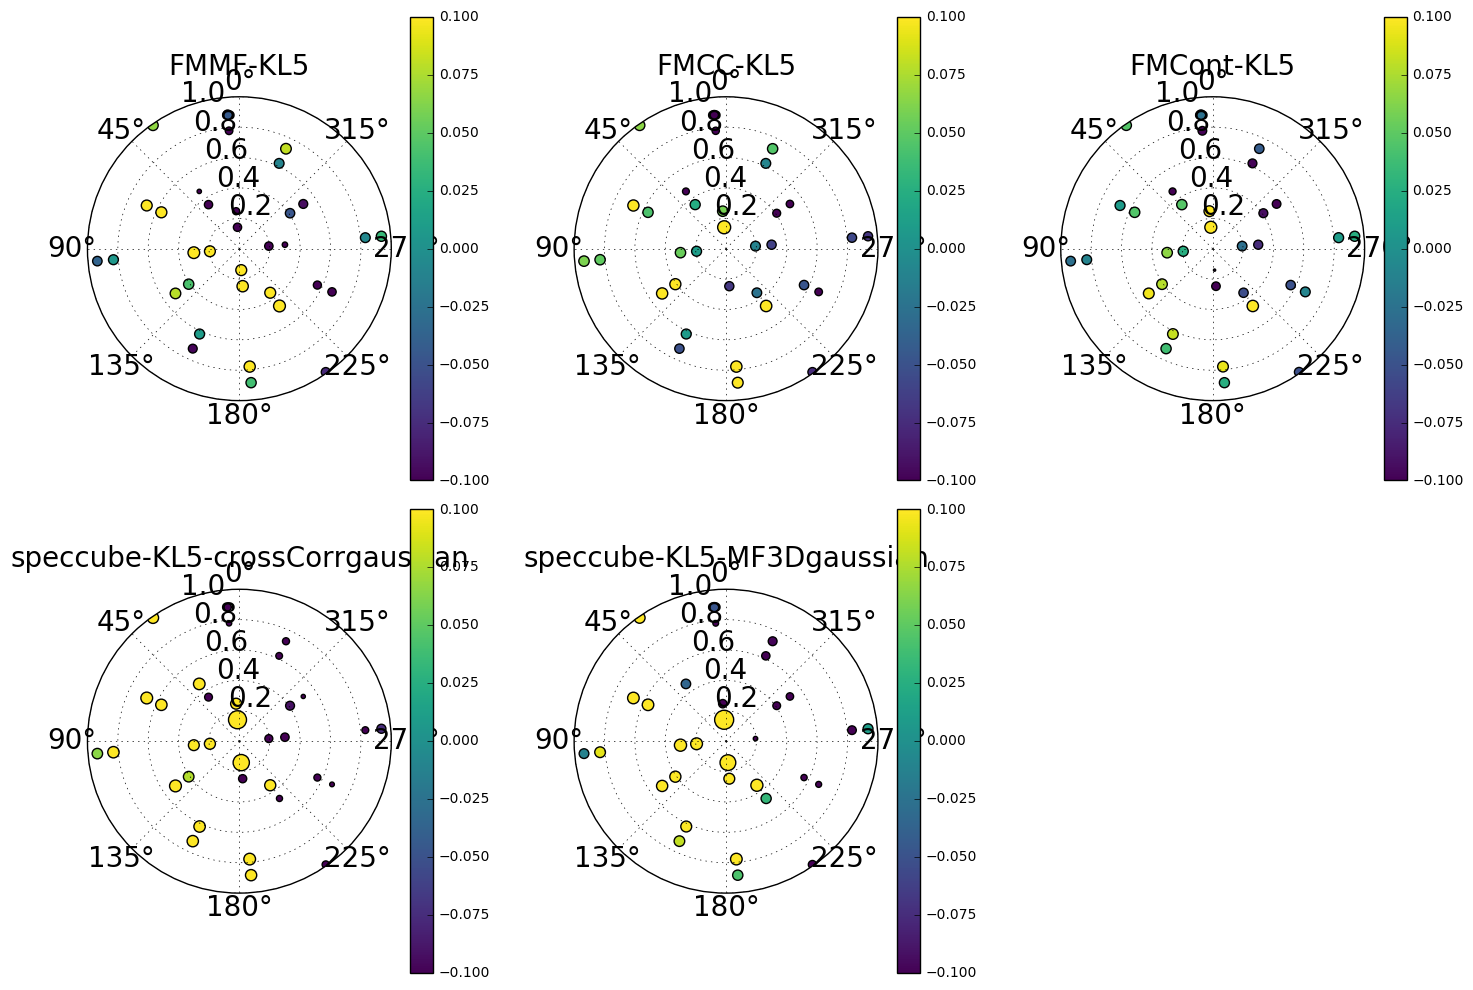

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

inputDir = "/home/sda/jruffio/pyklip/tests/data/"
reduc_spectrum = "t600g100nc"
fakes_spectrum = "t1000g100nc"

suffix_list = ["FMMF-KL5","FMCC-KL5","FMCont-KL5",
               "speccube-KL5-crossCorrgaussian",
               "speccube-KL5-MF3Dgaussian"]
label_list = ["kpop_FMMF",]*5
color_list = ["red","blue","grey","pink","cyan"]


plt.figure(3,figsize=(15,10))
for k,(suffix,color,kpop_label) in enumerate(zip(suffix_list,color_list,label_list)):
    plt.subplot(2,3,k+1,projection="polar")
    with open(os.path.join(inputDir,kpop_label,reduc_spectrum,"conversion-"+suffix+'.csv'), 'rt') as cvs_conversion:
        cvs_reader = csv.reader(filter(lambda row: row[0]!="#",cvs_conversion),delimiter=' ')
        list_contrast = list(cvs_reader)
        contrast_str_arr = np.array(list_contrast, dtype='string')
        col_names = contrast_str_arr[0]
        contrast_arr = contrast_str_arr[1::].astype(np.float)
        sep_samples = np.squeeze(contrast_arr[:,np.where("Seps"==col_names)])
        pa_samples = np.squeeze(contrast_arr[:,np.where("PA"==col_names)])
        conversion = np.squeeze(contrast_arr[:,np.where("conversion"==col_names)])
        conversion_kMAD = np.squeeze(contrast_arr[:,np.where("kMAD"==col_names)])
        conversion_fit = np.squeeze(contrast_arr[:,np.where("fit"==col_names)])

    ax = plt.gca()
    plt.title(suffix,fontsize=20)
    sc = plt.scatter(np.radians(pa_samples),sep_samples,c=(conversion-conversion_fit)/conversion,s=100*(0.5+(conversion-conversion_fit)/conversion),cmap="viridis")
    ax.set_rmax(1.)
    ax.set_theta_zero_location("N")
    plt.colorbar(sc)
    plt.clim([-0.1,0.1])
    ax= plt.gca()
    plt.grid(True)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

plt.tight_layout()

## Advanced Features

### Spectrum Management

TODO. Transmission correction. Contrast Calibration.